# Intermediate Presentation Demo

## 1. Face Embedding

In [1]:
import os
import torch
import pytorch_lightning as pl
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from pytorch_lightning.loggers import TensorBoardLogger

from torch.utils.data import DataLoader, random_split
from torchvision import transforms

from dataset.LFWDataset import LFWDataset
from models.FaceNetPytorchLightning import LightningFaceNet

In [2]:
from utils.FaceEmbedder import FaceEmbedder


root = os.path.join('.', 'data', 'lfw_crop')
transform = transforms.Compose([
    transforms.Resize((250, 250)),
    transforms.ToTensor(), 
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)
embedder = FaceEmbedder(root, transform=transform, init_update=False)


In [3]:
import timeit

start = timeit.default_timer()
embedder.update()
stop = timeit.default_timer()

print("Runtime in seconds:", stop-start)

Create embedding space.
Create triplet selections.
Runtime in seconds: 1938.1254325220361


In [3]:
,root = os.path.join('.', 'data', 'lfw_crop')
transform = transforms.Compose([
    transforms.Resize((250, 250)),
    transforms.ToTensor(), 
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)
dataset = LFWDataset(root, transform=transform)

In [4]:
iterator = iter(dataset)
label, anchor, positive, negative = next(iterator)


In [5]:
def show_img(img):
    img = (img * 0.5) + 0.5
    img = img.numpy()
    img = np.transpose(img, (1, 2, 0))
    return img

Aaron_Peirsol


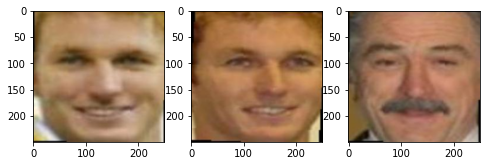

In [6]:
print(label)
fig=plt.figure(figsize=(8, 8))
for i, img in enumerate([anchor, positive, negative]):
    fig.add_subplot(1, 3, i+1)
    plt.imshow(show_img(img))

In [7]:
train_length = int(0.8 * len(dataset))
val_length = test_length = (len(dataset) - train_length) // 2

train_set, val_set, test_set = random_split(dataset, [train_length, val_length, test_length])

train_loader = DataLoader(train_set, batch_size=16, num_workers=0)
val_loader = DataLoader(val_set, batch_size=16, num_workers=0)
test_loader = DataLoader(test_set, batch_size=16, num_workers=0)

In [8]:
hparams = {'lr': 0.001, 'margin': 1, 'optimizer': 'Adam'}
model = LightningFaceNet(hparams, 1680, root, transform=transform)

logger = TensorBoardLogger('tb_logs', name='FaceNet on LFW')

trainer = pl.Trainer(
    gpus=1 if torch.cuda.is_available() else 0,
    max_epochs=2,
    logger=logger
)

Create embedding space.
Could not load pretrained model. Continue without weights


NameError: name 'device' is not defined

In [9]:
trainer.fit(model, train_loader, val_loader)


  | Name         | Type              | Params
---------------------------------------------------
0 | model        | FaceNet           | 40.5 M
1 | criterion    | TripletMarginLoss | 0     
2 | train_metric | EmbeddingAccuracy | 0     
3 | val_metric   | EmbeddingAccuracy | 0     
4 | test_metric  | EmbeddingAccuracy | 0     
---------------------------------------------------
40.5 M    Trainable params
0         Non-trainable params
40.5 M    Total params


c:\users\thien\.virtualenvs\ibm-labcourse-jcrwhed5\lib\site-packages\torch\utils\data\_utils\fetch.py:44: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,2

1

In [9]:
torch.save(model.state_dict(), './models/FaceNetOnLFW.pth')

In [10]:
trainer.test(model, test_loader)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': tensor(0.5000, device='cuda:0'),
 'test_loss': tensor(0.6085, device='cuda:0'),
 'val_acc': tensor(0.5000, device='cuda:0'),
 'val_loss': tensor(0.5699, device='cuda:0')}
--------------------------------------------------------------------------------


[{'val_loss': 0.5699176788330078,
  'val_acc': 0.5,
  'test_loss': 0.6084917187690735,
  'test_acc': 0.5}]

## 2. Face Registration and Recognition

In [12]:
# imports
import torch.nn.functional as F
import torch
from face_recognition.faceEmbeddingModel import faceEmbeddingModel
from face_recognition.reg_database import RegistrationDatabase
from face_recognition.prep import load_and_transform_img
import sys
import numpy as np

**Use pretrained model**

In [13]:
embedding_model = faceEmbeddingModel().eval()

In [14]:
database = RegistrationDatabase()

Database already exists. Pickle file will be loaded...


### Data Augmentation

In [15]:
import torch
from torchvision import transforms
from PIL import Image

In [16]:
def load_and_transform_img(path):

    trfrm = transforms.Compose([transforms.Resize(224),  
                           transforms.ToTensor()]) 
                           #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
    #prepare preprocess pipeline
    augmentation_1 = transforms.Compose([
        transforms.ToPILImage(),
        transforms.ColorJitter(brightness=0.8, contrast=0, saturation=0, hue=0),
        transforms.ToTensor()])   

    augmentation_2 = transforms.Compose([
        transforms.ToPILImage(),
        transforms.ColorJitter(brightness=0, contrast=0.8, saturation=0, hue=0),
        transforms.ToTensor()]) 
    
    augmentation_3 = transforms.Compose([
        transforms.ToPILImage(),
        transforms.ColorJitter(brightness=0, contrast=0, saturation=0.8, hue=0),
        transforms.ToTensor()]) 
    
    augmentation_4 = transforms.Compose([
        transforms.ToPILImage(),
        transforms.ColorJitter(brightness=0, contrast=0, saturation=0, hue=0.1),
        transforms.ToTensor()]) 
    
    augmentation_5 = transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomHorizontalFlip(p=1),
        transforms.ToTensor()])   

    augmentation_6 = transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomPerspective(distortion_scale=0.1, p=1),
        transforms.ToTensor()])  


    # read the image and transform it into tensor then normalize it with our trfrm function pipeline
    reg_img = trfrm(Image.open(path)).unsqueeze(0)

    reg_img_1 = reg_img
    # with newer torchvision version, one can also transform tensor batches (but cannot update torchvision)
    # Thus, I have to convert it to an PIL image first
    reg_img_2 = augmentation_1(reg_img.squeeze(0)).unsqueeze(0)
    reg_img_3 = augmentation_2(reg_img.squeeze(0)).unsqueeze(0)
    reg_img_4 = augmentation_3(reg_img.squeeze(0)).unsqueeze(0)
    reg_img_5 = augmentation_4(reg_img.squeeze(0)).unsqueeze(0)
    reg_img_6 = augmentation_5(reg_img.squeeze(0)).unsqueeze(0)
    reg_img_7 = augmentation_6(reg_img.squeeze(0)).unsqueeze(0)
   

    return reg_img_1, reg_img_2, reg_img_3, reg_img_4, reg_img_5, reg_img_6, reg_img_7

In [17]:
path = './face_recognition/test_registration_images/Vladimir_01.ppm'
reg_img_1, reg_img_2, reg_img_3, reg_img_4, reg_img_5, reg_img_6, reg_img_7 = load_and_transform_img(path)

Text(0.5, 1.0, 'Random Perspective')

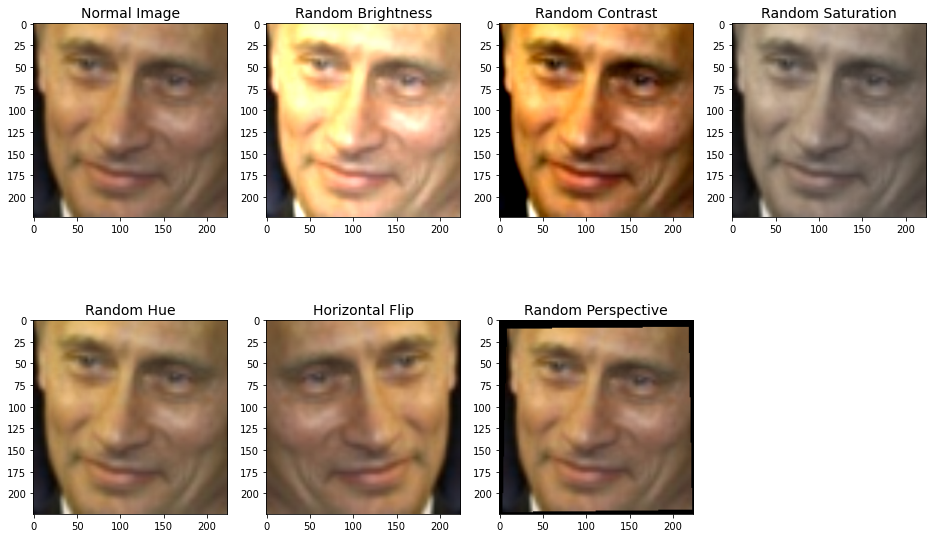

In [18]:
fig=plt.figure(figsize=(16, 10))

# Normal image
fig.add_subplot(2,4,1)
plt.imshow(reg_img_1[0].permute(1, 2, 0))
plt.title("Normal Image", {'fontsize': 14})

# Random Brightness (between 0.5 and 1.5)
fig.add_subplot(2,4,2)
plt.imshow(reg_img_2[0].permute(1, 2, 0))
plt.title("Random Brightness", {'fontsize': 14})

# Random Contrast (between 0.5 and 1.5)
fig.add_subplot(2,4,3)
plt.imshow(reg_img_3[0].permute(1, 2, 0))
plt.title("Random Contrast", {'fontsize': 14})

# Random Saturation (between 0.5 and 1.5) (Value of how dominant the color is, or how colorful the face looks)
fig.add_subplot(2,4,4)
plt.imshow(reg_img_4[0].permute(1, 2, 0))
plt.title("Random Saturation", {'fontsize': 14})

# Random Hue (between -0.3 and 0.3)
fig.add_subplot(2,4,5)
plt.imshow(reg_img_5[0].permute(1, 2, 0))
plt.title("Random Hue", {'fontsize': 14})

# Horizontal Flip
fig.add_subplot(2,4,6)
plt.imshow(reg_img_6[0].permute(1, 2, 0))
plt.title("Horizontal Flip", {'fontsize': 14})

# Random Perspective
fig.add_subplot(2,4,7)
plt.imshow(reg_img_7[0].permute(1, 2, 0))
plt.title("Random Perspective", {'fontsize': 14})

## Face Registration
### Registration of 10 people

In [19]:
def register_people():

    paths = []
    paths.append('./face_recognition/test_registration_images/Aaron_01.ppm')
    paths.append('./face_recognition/test_registration_images/Abdoulaye_01.ppm')
    paths.append('./face_recognition/test_registration_images/George_01.ppm')
    paths.append('./face_recognition/test_registration_images/Hugo_01.ppm')
    paths.append('./face_recognition/test_registration_images/Ian_01.ppm')
    paths.append('./face_recognition/test_registration_images/Jennifer_01.ppm')
    paths.append('./face_recognition/test_registration_images/Kofi_01.ppm')
    paths.append('./face_recognition/test_registration_images/Lleyton_01.ppm')
    paths.append('./face_recognition/test_registration_images/Vladimir_01.ppm')
    paths.append('./face_recognition/test_registration_images/Yashwant_01.ppm')


    names = []
    names.append('Aaron')
    names.append('Abdoulaye')
    names.append('George')
    names.append('Hugo')
    names.append('Ian')
    names.append('Jennifer')
    names.append('Kofi')
    names.append('Lleyton')
    names.append('Vladimir')
    names.append('Yashwant')


    for i in range(len(names)):
        # data augmentation
        reg_img_1, reg_img_2, reg_img_3, reg_img_4, reg_img_5, reg_img_6, reg_img_7 = load_and_transform_img(paths[i])
        
        # create embeddings
        img_embedding_tensor_1 = embedding_model(reg_img_1)
        img_embedding_tensor_2 = embedding_model(reg_img_2)
        img_embedding_tensor_3 = embedding_model(reg_img_3)
        img_embedding_tensor_4 = embedding_model(reg_img_4)
        img_embedding_tensor_5 = embedding_model(reg_img_5)
        img_embedding_tensor_6 = embedding_model(reg_img_6)
        img_embedding_tensor_7 = embedding_model(reg_img_7)
        
        # save embeddings to database
        database.face_registration(names[i],img_embedding_tensor_1)
        database.face_registration(names[i],img_embedding_tensor_2)
        database.face_registration(names[i],img_embedding_tensor_3)
        database.face_registration(names[i],img_embedding_tensor_4)
        database.face_registration(names[i],img_embedding_tensor_5)
        database.face_registration(names[i],img_embedding_tensor_6)
        database.face_registration(names[i],img_embedding_tensor_7)

In [20]:
register_people()

In [21]:
database.database.head(15)

,label,embedding,threshold
0,Aaron,"[[0.9383862, 0.15436025, 0.94003713, 0.5252996...",99.899353
1,Aaron,"[[0.9188569, 0.16816679, 0.92709255, 0.5611549...",99.878479
2,Aaron,"[[0.8706299, 0.041423146, 1.0380386, 0.5966872...",99.951149
3,Aaron,"[[0.93572015, 0.13627967, 0.9416798, 0.5276328...",99.893959
4,Aaron,"[[0.940354, 0.14842777, 0.9461918, 0.520691, -...",99.898186
5,Aaron,"[[0.9067745, 0.16255678, 0.9034153, 0.55157685...",99.844376
6,Aaron,"[[0.9051138, 0.16912332, 0.9516585, 0.53240824...",99.884857
7,Abdoulaye,"[[0.7453778, 0.14829004, 0.96528894, 0.7662613...",99.695312
8,Abdoulaye,"[[0.8478909, 0.107008226, 1.0626982, 0.5579489...",99.989899
9,Abdoulaye,"[[0.713763, 0.03145517, 1.1312462, 0.7431244, ...",99.797234


### Face Recognition inference step

In [22]:
def face_recognition(path):
    img_1, _, _, _, _, _, _ = load_and_transform_img(path)
    img_embedding_tensor = embedding_model(img_1)
    closest_label, check = database.face_recognition(img_embedding_tensor)
    if check == 'Access':
        print("Recognized person: ", closest_label)
        print("""
        
        
        --- Access permission ---
        
        
        """)
    elif check == 'Decline':
        print("Unknown Person")
        print("""
        
        
        !!! --- Permission declined --- !!!
        
        
        """)

### Inference with a REGISTERED image of my KNOWN friend Vladimir

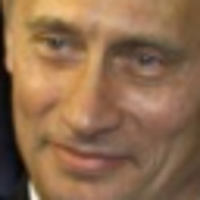

In [23]:
path = './face_recognition/test_registration_images/Vladimir_01.ppm'
known_example = Image.open(path)
known_example.resize((200,200))

In [24]:
face_recognition(path)

Recognized person:  Vladimir

        
        
        --- Access permission ---
        
        
        


### Inference with a NEW image of my KNOWN friend Vladimir

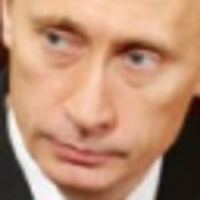

In [25]:
from PIL import Image
path = './face_recognition/test_recognition_images/Vladimir_04.ppm'
known_example = Image.open(path)
known_example.resize((200,200))

In [26]:
face_recognition(path)

Recognized person:  Vladimir

        
        
        --- Access permission ---
        
        
        


### Inference with an UNKNOWN random guy called "John"

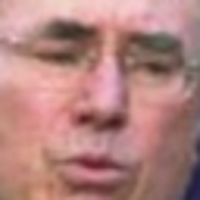

In [27]:
path = './face_recognition/test_recognition_images/John_04.ppm'
unknown_example = Image.open(path)
unknown_example.resize((200,200))

In [28]:
face_recognition(path)

Unknown Person

        
        
        !!! --- Permission declined --- !!!
        
        
        
